In [29]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
from IPython.display import clear_output
import sys
from random import shuffle
from collections import defaultdict

In [30]:
%matplotlib inline

## Bulding the racetrack

In [31]:
grid = np.zeros((6,9))
grid[0:3,-2] = -50
grid[1:4, 2] = -50
grid[-2, -4] = -50
START = (2,0)
END   = (0,8)
grid

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0., -50.,   0.],
       [  0.,   0., -50.,   0.,   0.,   0.,   0., -50.,   0.],
       [  0.,   0., -50.,   0.,   0.,   0.,   0., -50.,   0.],
       [  0.,   0., -50.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., -50.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

## Initialization

In [32]:
actions = ['u', 'd', 'r', 'l']

#TRANSITIONS for each (state, action) pair
trans = defaultdict(lambda : defaultdict(tuple))

#REWARDS
r     = defaultdict(int)

for row in range(6):
    for column in range(9):
        state = (row, column)
        if row==0 or grid[row-1, column] <0:
            trans[state][0] = state
        else:
            trans[state][0] = (row-1, column)
        
        if row==5 or grid[row+1, column] <0:
            trans[state][1] = state
        else:
            trans[state][1] = (row+1, column)
            
        if column == 8 or grid[row, column+1] <0:
            trans[state][2] = state
        else:
            trans[state][2] = (row, column+1)
            
        if column==0 or grid[row, column-1] <0:
            trans[state][3] = state 
        else:
            trans[state][3] = (row, column - 1)
        
        if state == END:
            r[state]= 0
        else:
            r[state]= -1

## Utils

In [33]:
def greedyAction(state, V):
    bestAction = -1
    qMax = -np.inf

    act_list = range(4)
    shuffle(act_list)
    
    for action  in act_list:
        nextState = trans[state][action]
        q_action = r[nextState] + V[nextState]
        if (q_action > qMax):
            qMax = q_action
            bestAction = action

    return bestAction


def getAveragePathLength(V):
    lenghts = []

    for _ in range(500):
        state = START
        nbSteps =0        
        
        while (state!=END):
            #print state
            #raw_input("Pausa")
            bestAction = greedyAction(state, V)
            nextState = trans[state][bestAction]
            nbSteps += 1
            state = nextState

        lenghts.append(nbSteps)

    return float(sum(lenghts))/len(lenghts)

## DP

In [34]:
V_Sync  = defaultdict(float)
nbSweeps_Sync  = 0 
nbBackups_Sync =0 

gamma = 1

delta = 10**(-7) + 1

#Average path length after each sweeps 
lenghts_DP = []

#number of backups after each sweep (= number of states)
backups_DP = []

while delta > 10**(-7):
    delta = 0 
    V_old = V_Sync.copy()
    nbSweeps_Sync +=1
    for row in range(6):
        for column in range(9):
            if grid[row,column] < 0:
                continue
            state = (row,column) 
            
            greedyAct    = greedyAction(state, V_old)
            nextState    = trans[state][greedyAct]
            qAction      = r[nextState] + gamma * V_old[nextState]                        
            if abs(qAction - V_old[state]) > delta :
                delta = abs(qAction - V_old[state])
                
            V_Sync[state] = qAction 
            nbBackups_Sync +=1
            
            #VISUALIZE UPDATES SEQUENTIALLY
            """
            clear_output()
            Vgrid = grid.copy()
            for state in V_Sync.keys():
                Vgrid[state] = V_Sync[state]
            print Vgrid
            sys.stdout.flush()
            time.sleep(0.2)
            """
    backups_DP.append(nbBackups_Sync)
    lenghts_DP.append(getAveragePathLength(V_Sync))

In [35]:
print "Toal number of sweeps:    ", nbSweeps_Sync
print "Total number of backups:  ", nbBackups_Sync

Toal number of sweeps:     15
Total number of backups:   705


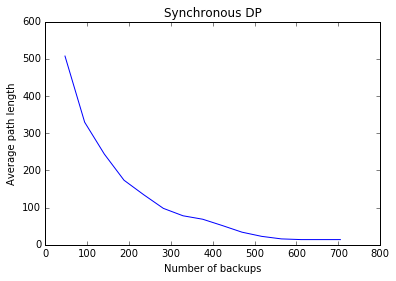

In [36]:
plt.plot(backups_DP, lenghts_DP )
plt.xlabel("Number of backups")
plt.ylabel("Average path length")
plt.title("Synchronous DP")
plt.savefig("images/DP", boxinches = "tight")
plt.show()

## Gauss - Seidel DP

In [37]:
V_GS  = defaultdict(float)
nbSweeps_GS  = 0
nbBackups_GS = 0

gamma = 1

backups_GS = []
lenghts_GS = []

#Random states ordering
states = [(i,j) for i in range(6) for j in range(9)]
shuffle(states)

delta = 10**(-7) + 1
while delta > 10**(-7):
    delta = 0 
    nbSweeps_GS +=1    
   
    for state in states:
        if grid[state] < 0:
            continue
            
        greedyAct    = greedyAction(state, V_GS)
        nextState    = trans[state][greedyAct]
        qAction      = r[nextState] + gamma * V_GS[nextState]   
        
        if abs(qAction - V_GS[state]) > delta :
            delta = abs(qAction - V_GS[state])

        V_GS[state] = qAction
        nbBackups_GS +=1            
    
        #VISUALIZE UPDATES SEQUENTIALLY
        """
        clear_output()
        Vgrid = grid.copy()
        for state in V_GS.keys():
            Vgrid[state] = V_GS[state]
        print Vgrid
        sys.stdout.flush()
        raw_input("Pausa")        
        """
    backups_GS.append(nbBackups_GS)
    lenghts_GS.append(getAveragePathLength(V_GS))

In [38]:
print "Toal number of sweeps:    ", nbSweeps_GS
print "Total number of backups:  ", nbBackups_GS

Toal number of sweeps:     15
Total number of backups:   705


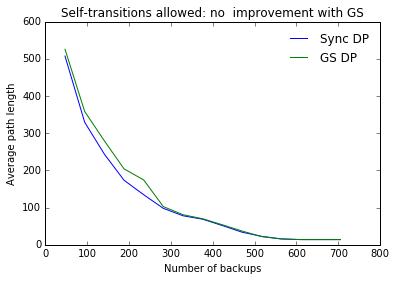

In [39]:
plt.plot(backups_DP, lenghts_DP , label= "Sync DP" )
plt.plot(backups_GS, lenghts_GS , label= "GS DP")
plt.xlabel("Number of backups")
plt.ylabel("Average path length")
plt.legend(loc="upper right", frameon = False)
plt.title("Self-transitions allowed: no  improvement with GS")
plt.savefig("images/DP-GS", boxinches = "tight")
plt.show()

## RTDP

In [40]:
gamma = 1


trials_simulations = []

for _ in range(500):
    nbEpisodes = 0
    nbBackups_RTDP =0
    V_RTDP = defaultdict(float)
    delta = 10**(-7) + 1
    trials_stats = []
    while delta > 10**(-7):
    
        delta = 0 
        state = START
        nbEpisodes +=1
        nbSteps = 0

        while state!= END:    
            nbSteps += 1            
                        
            greedyAct    = greedyAction(state, V_RTDP)
            nextState    = trans[state][greedyAct]
            qAction      = r[nextState] + gamma * V_RTDP[nextState]   

            if abs(qAction - V_RTDP[state]) > delta :
                delta = abs(qAction - V_RTDP[state])

            V_RTDP[state] = qAction
            nbBackups_RTDP +=1
            
            state = nextState           
        
        trials_stats.append((nbSteps, nbBackups_RTDP))
    trials_simulations.append(trials_stats)

In [41]:
#Get maximum number of trials 
maxNbTrials = max([len(t) for t in trials_simulations])

#Since every simulation has different number of trials, make it equal for all so that I can average over all simulations
for idx,_ in enumerate(trials_simulations):
    while (len(trials_simulations[idx]) < maxNbTrials):
        trials_simulations[idx].append(trials_simulations[idx][-1])
        
simulationsMaxtrix = np.array(trials_simulations)
simulationsMaxtrix.shape

(500L, 36L, 2L)

In [42]:
lengthsMatrix = simulationsMaxtrix[:,:,0]
backupsMatrix = simulationsMaxtrix[:,:,1]
lengthsMatrix.shape

(500L, 36L)

In [43]:
lenghtsAvg = lengthsMatrix.mean(axis=0)
backupsAvg = backupsMatrix.mean(axis=0)

In [44]:
print "Max total number of backups (over all simulations):  ", np.max(backupsMatrix[:,-1], axis = 0)
print "Min total number of backups (over all simulations):  "  , np.min(backupsMatrix[:,-1], axis = 0)

Max total number of backups (over all simulations):   860
Min total number of backups (over all simulations):   692


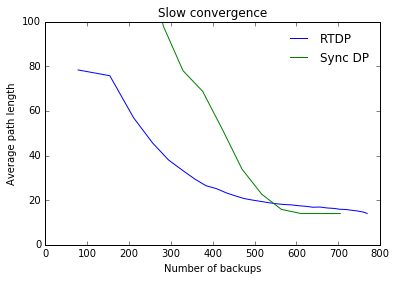

In [45]:
plt.plot(backupsAvg, lenghtsAvg , label = "RTDP")
plt.plot(backups_DP, lenghts_DP , label= "Sync DP" )
plt.xlabel("Number of backups")
plt.ylabel("Average path length")
plt.legend(loc="upper right", frameon = False)
plt.ylim(0,100)
plt.title("Slow convergence")
plt.savefig("images/DP-rtdp-conver", boxinches = "tight")
plt.show()

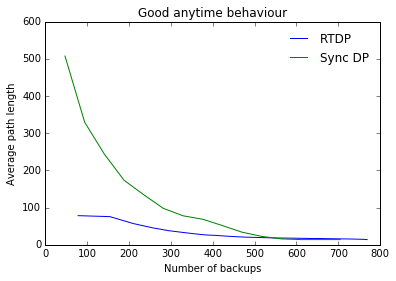

In [46]:
plt.plot(backupsAvg, lenghtsAvg , label = "RTDP")
plt.plot(backups_DP, lenghts_DP , label= "Sync DP" )
plt.xlabel("Number of backups")
plt.ylabel("Average path length")
plt.legend(loc="upper right", frameon = False)
plt.title("Good anytime behaviour")
plt.savefig("images/DP-rtdp-anytime", boxinches = "tight")
plt.show()

## LRTDP

In [47]:
def checkSolved(state, epsilon, V, nbBackups):
    rv = True
    openStack = []
    closedStack = []
    openUclosed = set()
    if not states_solved[state]:
        openStack.append(state)
        openUclosed.add(state)

    # print state
    while (len(openStack) != 0):
        s = openStack.pop()
        closedStack.append(s)  

        if s == END:
            rv = True
            continue

        # greedy
        bestAction = greedyAction(s, V)
        nextState = trans[s][bestAction]
        # Qvalue
        Qvalue = r[nextState] + gamma * V[nextState]
        # Residual
        Residual = abs(V[s] - Qvalue)

        if Residual > epsilon:
            rv = False
            continue

        if not states_solved[nextState] and nextState not in openUclosed:
            openStack.append(nextState)
            openUclosed.add(nextState)

    if rv:
        for s1 in closedStack:
            states_solved[s1] = True
    else:
        while (len(closedStack) != 0):
            s = closedStack.pop()
            bestAction = greedyAction(s, V)
            nextState = trans[s][bestAction]
            Qvalue = r[nextState] + gamma * V[nextState]
            V[s] = Qvalue
            nbBackups +=1

    return rv, nbBackups

def getPathLengthFromState(V, state):  
    start = time.time()
    nbSteps =0
   
    while (state!=END):
        bestAction = greedyAction(state, V)
        while not states_solved[trans[state][bestAction]]:
            bestAction = greedyAction(state, V)
            
        nextState = trans[state][bestAction]
        nbSteps += 1        
        
        #DEBUG for possible loops
        """ 
        if (time.time()-start)>=1:
            print state, bestAction, nextState, states_solved[state]           
            Vgrid = grid.copy()
            for state in V.keys():
                Vgrid[state] = V[state]
            print Vgrid
            sys.stdout.flush()
            raw_input("Pausa")
        """
        state = nextState
        
    return nbSteps

In [48]:
trials_simulations = []

for it in range(500):    
    nbBackups_LRTDP =0
    states_solved = defaultdict(lambda: False)
    V_LRTDP = defaultdict(float)
    epsilon = 10**(-3) 
    
    trials_stats = []
    clear_output()    
    print it
    sys.stdout.flush()
    while not states_solved[START]:
        visitedStack = []
        state = START
        nbSteps = 0
        while not states_solved[state]:
            visitedStack.append(state)
            if state == END:
                break

            bestAction = greedyAction(state, V_LRTDP)
            nextState = trans[state][bestAction]
            Qvalue = r[nextState] + gamma * V_LRTDP[nextState]
            V_LRTDP[state] = Qvalue
            nbBackups_LRTDP +=1

            nbSteps +=1
            state = nextState     
            
        
        nbSteps += getPathLengthFromState(V_LRTDP, state)
        
        
        while len(visitedStack) != 0:
            s = visitedStack.pop()
            SOLVED, nbBackups_LRTDP = checkSolved(s, epsilon, V_LRTDP, nbBackups_LRTDP)
            if not SOLVED:
                break  
                
        trials_stats.append((nbSteps, nbBackups_LRTDP))
    trials_simulations.append(trials_stats)

499


In [49]:
#get maximum number of trials 
maxNbTrials = max([len(t) for t in trials_simulations])
for idx,_ in enumerate(trials_simulations):
    while (len(trials_simulations[idx]) < maxNbTrials):
        trials_simulations[idx].append(trials_simulations[idx][-1])
        
simulationsMaxtrix = np.array(trials_simulations)
simulationsMaxtrix.shape

(500L, 25L, 2L)

In [50]:
lengthsMatrix = simulationsMaxtrix[:,:,0]
backupsMatrix = simulationsMaxtrix[:,:,1]
lengthsMatrix.shape

(500L, 25L)

In [51]:
lenghtsAvg_LRTDP = lengthsMatrix.mean(axis=0)
backupsAvg_LRTDP = backupsMatrix.mean(axis=0)

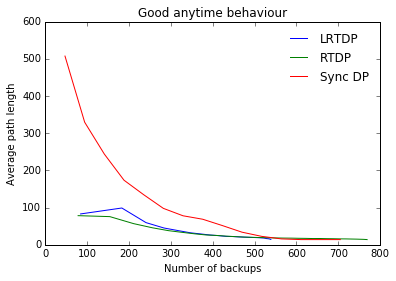

In [52]:
plt.plot(backupsAvg_LRTDP, lenghtsAvg_LRTDP, label = "LRTDP")
plt.plot(backupsAvg, lenghtsAvg , label = "RTDP")
plt.plot(backups_DP, lenghts_DP , label= "Sync DP" )
plt.xlabel("Number of backups")
plt.ylabel("Average path length")
plt.legend(loc="upper right", frameon = False)
plt.title("Good anytime behaviour")
plt.savefig("images/DP-rtdp-lrtdp-anytime", boxinches = "tight")
plt.show()

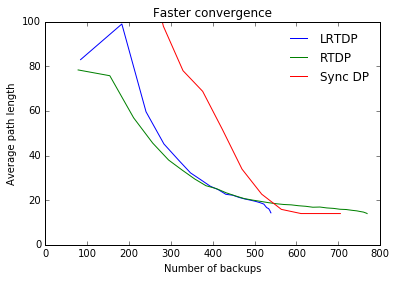

In [53]:
plt.plot(backupsAvg_LRTDP, lenghtsAvg_LRTDP, label = "LRTDP")
plt.plot(backupsAvg, lenghtsAvg , label = "RTDP")
plt.plot(backups_DP, lenghts_DP , label= "Sync DP" )
plt.xlabel("Number of backups")
plt.ylabel("Average path length")
plt.legend(loc="upper right", frameon = False)
plt.title("Faster convergence")
plt.ylim(0,100)
plt.savefig("images/DP-rtdp-lrtdp-conver", boxinches = "tight")
plt.show()